# Project Basics Of Mobile Robotics

Group members T40:

|  ID | Email address | Name |
| ------------ | ------------ | ------------ |
|  314353 | jean.cordonnier@epfl.ch  | Jean François Marie Cordonnier  |
|  375700 | paulo.khayat@epfl.ch  |  Paulo Emil Khayat |
|  376792 | adriana.orellanatorrico@epfl.ch  |  Adriana Nancy Orellana Torrico |
| 376825 | mustafa.gursoy@epfl.ch | Mustafa Emre Gürsoy |

### Introduction

In our robotics project, we have set up a white board as the main area for our robot to navigate and avoid obstacles. This board measures 117 cm in width and 73.5 cm in height.

Our environment includes polygon-shaped obstacles like triangles and rectangles, all painted in green. There's also a goal for the robot to reach, marked by a red circle. To track our robot's location and direction, we've placed an Aruco marker on top of it.
For navigation, we're using a combination of techniques: the A* (A star) algorithm helps in planning the best path globally, while local navigation let the robot avoid obstacles in real-time. We also use a Kalman filter, which helps in accurately predicting the robot's future states based on its current state and movements.

## Components

This section outlines the developed components for our solution.

### Computer Vision Module Overview

The computer vision module serves as the robotic system's primary sensory input, akin to a set of eyes. This module relies on an externally mounted camera, strategically positioned to capture a comprehensive view of the map.

#### 1. Map Detection
The first step in our computer vision processing pipeline is the detection and isolation of the map within the camera's field of view. We start this process by applying a bilateral filter to the captured image. This specific type of filter is adept at reducing unwanted noise while preserving crucial edge details, which are vital for accurate map contour detection.

Once the image is filtered, we convert it to grayscale, a necessary preprocessing step before applying the Canny edge detection algorithm. The Canny algorithm excels in identifying the edges within the image, essential for finding the map's boundaries.

After edge detection, we perform a Gaussian blur. This step helps in further smoothing the image and removing any residual noise that could interfere with contour detection.

<img src="images\camera_image1.png" alt="Camera original image" style="width: 500px;padding-top:20px"/>
<img src="images\camera_image.png" alt="Camera preprocessed image" style="width: 500px;padding-top:20px"/>

With these preprocessing steps completed, we proceed to identify the map's outermost contours. Specifically, we focus on the largest contour, as it is presumed to represent the map. Utilizing OpenCV's `cv2.approxPolyDP` function, we approximate this contour to a polygon, simplifying our representation of the map's shape.

The final step in map detection is perspective transformation. We use OpenCV's `cv2.getPerspectiveTransform` and `cv2.warpPerspective` functions to adjust the camera's view, focusing solely on the map. This transformation is critical as it enables more precise detection and tracking of the robot and obstacles, and facilitates accurate path planning.

<img src="images\map_img.png" alt="Transformed map image" style="width: 500px;padding-top:20px"/>

#### 2. Obstacle Detection
Post map detection and perspective transformation, our attention shifts to obstacle detection. The key challenge here is to distinguish obstacles from other elements within the map such as the goal and the thymio robot. We address this by specifically targeting green-colored shapes.

The process begins with a Gaussian blur to reduce noise, followed by conversion of the image to the HSV color space. HSV is particularly suited for color-based segmentation tasks in computer vision. We then apply a green color filter, effectively isolating the obstacles.

Finally, we identify and approximate the contours of these green shapes, converting them into polygonal representations. These polygons are then utilized in the A* algorithm for path planning, ensuring the robot can navigate around these obstacles efficiently.

#### 3. Goal Detection
The approach for goal detection is similar to the obstacle detection, with the primary difference being the target color - red instead of green. Upon identifying the red areas, we approximate these regions to a circular shape. The center of this circle is deemed to be the goal's location, providing a clear target for the robot to reach.

#### 4. Thymio Robot Detection
For detecting the Thymio robot, we initially experimented with the YOLOv8 deep learning model. However, we eventually opted for a more streamlined and dataset-independent solution: using an Aruco marker.

The detection process involves utilizing OpenCV's `aruco.detectMarkers` to locate the Thymio robot within the map. The position is determined through the `drawDetectedMarkers` function. To get the robot's precise center, we calculate the mean of the x and y coordinates of the marker's corners. Additionally, the orientation angle is computed using the arctangent of the difference between the top left and right corners of the marker. Also, it is important to note that the first time that the script detects the thimyo that determines the start position for the global path planning.

This method provides a reliable and efficient means of tracking the robot's position and orientation, crucial for effective navigation and interaction within the mapped environment.

#### Results

This is the result after detecting the obstacles, the thymio robot and the goal:

<img src="images\map_img_contours.png" alt="Computer vision results" style="width: 500px;padding-top:20px"/>

You can find all the code of the computer vision in ```computer_vision.py``` file and call it in ```camera_main.py``` located on vision folder.

## Global navigation

A common pathfinding algorithm in computer science and artificial intelligence is the A* (A-star) algorithm. Its purpose is to determine the shortest path on a graph or grid between a starting point and a goal point. Combining the ideas of Greedy Best-First Search and Dijkstra's algorithm, A* uses a heuristic function to effectively direct the search.

#### Important attributes:

Optimality: If certain requirements are satisfied, A* ensures that the shortest path will be found. 

Heuristic Guidance: A* estimates the cost from the current node to the goal using a heuristic function, commonly referred to as the "h-value". By directing the search, this heuristic increases algorithmic efficiency by examining the most promising paths first. We are using the Euclidean distance to the end goal as our heuristic function.

Various methods can be employed to apply the A* algorithm on a map, including the fixed-grid size approach, Voronoi diagrams, visibility graphs, and cell decomposition methods. Each method offers distinct advantages and considerations for pathfinding applications.

In our project, we assessed two primary pathfinding approaches: the fixed-grid size method and the visibility graph. Although the visibility graph demonstrated a slightly faster computation time, the difference was not substantial. However, a critical drawback surfaced with the visibility graph method, as it significantly reduced the number of reachable points, resulting in suboptimal solutions.

You can see our visibility graph and an usage of it in an A* algorithm below: 

### Visibility Graph
<img src="images\vis_graph.jpeg" alt="Visibility Graph" style="width: 500px;"/>

### Implementation with A*
<img src="images\vis_graph_path.jpeg" alt="Visibility Graph Path" style="width: 500px;"/>

Given that computation time differences were marginal, we decided to favor the fixed-grid size approach. This method involves dividing the map into uniform squares of predetermined cell sizes and utilizing obstacle masks generated through computer vision to construct a grid. The A* algorithm is then applied to this grid to determine the most efficient path.

For the implementation, you can see the pseudocode below. For the actual function you can go to ".\planning\Astar.py". 

### A* Algorithm
<img src="images\Astar_alg.png" alt="Algorithm" style="width: 500px;"/> 

We are displaying the A* exploration in real time, and an screenshot of such display can be seen below:

<img src="images\Astar_explore2.png" alt="Exploration" style="width: 500px;"/>

We are also displaying the grid and the found path on the the map. You can see the screenshot of it below:

<img src="images\Astar_path2.png" alt="Path" style="width: 500px;"/>

The above is done by three functions: "create_grid", "draw_grid_on_map", and "draw_grid_path".

You can see the pseudocodes for them below. To see their real implementations you need to go to ".\vision\computer_vision.py" and you will find them there.

### Creating the Grid
<img src="images\create_grid.png" alt="Path" style="width: 500px;"/>

### Drawing the Grid on the Map
<img src="images\draw_grid.png" alt="Path" style="width: 500px;"/>

### Drawing the Path on the Map
<img src="images\draw_path.png" alt="Path" style="width: 500px;"/>






## Path Following

Responsible: Paulo Khayat

The path following initializes the moment the path planning part of the camera vision is done.

The robot class is initalized with the following information:
```
robot_position = aruco_position #a tuple
robot_angle = aruco_angle #(an integer)
path = calculated_path[]  #(an array of tuple points)
```

The robot takes this series of points stored in the path, and does its best to follow along it

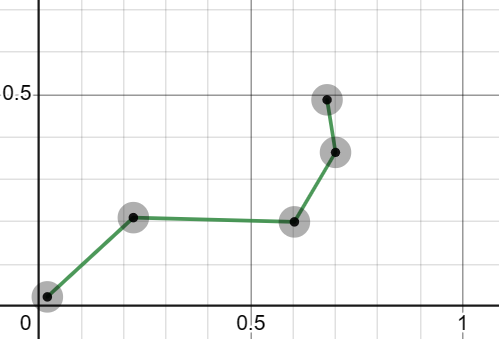

### The Idea:
The robot will save it's progress along the path, find a point ahead on the path, and try to reach it.
This point will be called from here on out a **lookahead point**; you can think of it as a carrot on a stick,
the robot tries to reach it but it keeps getting further away.

### Implementation:
The path following logic has two relevant functions, and the robot driving also has two functions of note.

#### Path following: get_closest_edge
(this function is inside `src/robot_drive/path_following.py`)
This function is relatively straightforward. given the list of points in our path,
we return 3 variables: the index of the nearest edge, the distance to that edge, and our projection on that edge

This is done by calculating the [projection of a point on a line](https://stackoverflow.com/questions/61341712/calculate-projected-point-location-x-y-on-given-line-startx-y-endx-y). The only difference i've made, is I don't assume the edge is infinite.
If the projection goes beyond the length of the edge, I limit it to the closer end.
```python
t = (pr[0] * vecpath[0] + pr[1] * vecpath[1])/(vecpath[1]*vecpath[1] + vecpath[0]*vecpath[0]) # Percentage on the current line
# Create a bounded projection:
# Projection is the closest point on the line to our robot.
#  this differs from a regular projection because our line is finite.
if(t < 0):
    projection = p1
elif (t>1):
    projection = p2
else:
    projection = (vecpath[0]*t + p1[0], vecpath[1]*t + p1[1])
```
For the example path presented above, the distances would look like this:

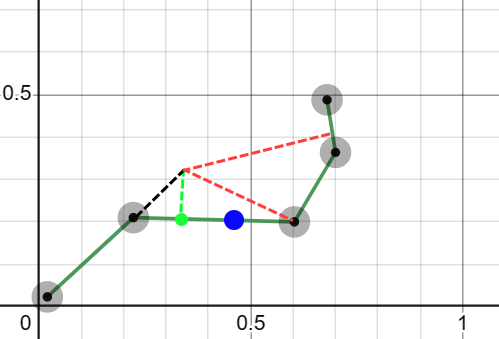

The closest edge is edge 1, which distance is seen in green.
Notice how the distance to edge 0 would be smaller if not for the alteration in the formula.

The red distances and the blue lookahead point will be explained below

#### Path following: get_closest_edge
Now that we can get the closest point to the path, we calculate a point 

# Bayesian Filter
This section has been written and the code made by Jean Cordonnier
## Introduction
We decided to go with a kalman filter as our bayesian filter. Our choice has been made based on 2 factors: it does not take big computational power (like the particle filter) and we assumed gaussian noise on the system. To implement the filter we used a python library from GitHub : https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/. The installation is in requirement.txt. 

To deal with the non-linearities in the orientation and position (we needed to change frame using the angle of the robot for the acceleration ad the velocity) and to deal with the format of the measurement (position ,velocity and acceleration being 2 dimensions variables and heading and spin (dheading/dt) being one dimensionnal) we decided to go with two kalmans: One for the position and one for the orientation. We will refer to them as kf_pos and kf_rot. Both are implemented in a kalman class defined in kalman.py
## Kalman for Position implementation
### Choice for measurement and state variables
For our measurements we used the data from the accelerometers, the average of the velocity of the wheels and the position from the camera. 
The kalman coordinates are exprimed in the local frame (with 0,0 being the top left corner) and the velocity and the accelerometers were exprimed in the body frame (centered with the robot) we had to do a coordinate change represented by this function: 
```python
#Change from body frame to local frame
def change_frame(body_data,body_orientation):
    '''
    Change from body frame to local frame.

    Parameters:
    - body_data: Data expressed in the body frame.
    - body_orientation: Orientation of the robot in the local frame (from kf_rot).

    Returns:
    Data expressed in the local frame.
    '''
    R = np.array([[np.cos(body_orientation), -np.sin(body_orientation)],
                  [np.sin(body_orientation), np.cos(body_orientation)]])
    accel_local = R.dot(body_data)
    return accel_local
```
The kf_pos has the following state variables (in the local frame): [positionx, positiony, velocityx, velocityy, accelerationx, accelerationy]. We also needed to define the F matrix linking the previous state to the next state such that x_next = F*x_previous. We defined it based on simple movement equation. Since the measurements dont have the same refresh rate we have to update the F matrix at every iteration depending on dt. 
```python
self.kf_pos.F = np.array([[1,0,dt,0,0.5*dt**2,0],
                          [0,1,0,dt,0,0.5*dt**2],
                          [0,0,1,0,dt,0],
                          [0,0,0,1,0,dt],
                          [0,0,0,0,1,0],
                          [0,0,0,0,0,1]])
```
One of the challenge we had to face was to manage to give the measurements with different frequencies. The solution we chose was to declare only two measurement in the declaration of the function and adapt the H matrix (linking the measurement z and the state x such that z = H*x) depending on which type of measurement it was. Which gave those results: 
```python
#for the acceleration
self.kf_pos.H = np.array([[0,0,0,0,1,0],
                         [0,0,0,0,0,1]])
                         #for the acceleration
self.kf_pos.H = np.array([[0,0,1,0,0,0],
                         [0,0,0,1,0,0]])
#for the acceleration
self.kf_pos.H = np.array([[1,0,0,0,0,0],
                         [0,1,0,0,0,0]])
```

The other challenge was to compute the process noise matrix Q. We assumed the noises to be independent so the non-diagonal terms had to be zero. For the diagonal terms we found our answer here: https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/07-Kalman-Filter-Math.ipynb. We don't really understand the 'why' of the math behind it but the kalman converged with this Q matrix so we are happy with it (and it did not work with other tries)
The final implementation of the Q matrix was this: 
```python
#compute Q according to dt 
        self.kf_pos.Q = np.array([
        [1/4 * noise**2 * dt**4, 0, 0, 0, 0, 0],
        [0, 1/4 * noise**2 * dt**4, 0, 0, 0, 0],
        [0, 0, noise**2 * dt**2, 0, 0, 0],
        [0, 0, 0, noise**2 * dt**2, 0, 0],
        [0, 0, 0, 0, noise**2, 0],
        [0, 0, 0, 0, 0, noise**2]])
```
In the end we had to compute the noise of each measurement. We assumed it to be white noise for all measurement and to be equivalent for the x and y part. The process to calculate the noise will be detailled below. For the implementation of the measurement noise matrix we used diagonal matrix with the covariance of the measurement: 

```python
#for acceleration
self.kf_pos.R = (self.ACCEL_NOISE**2)*np.eye(2)
#for velocity
self.kf_pos.R = (self.VEL_NOISE**2)*np.eye(2)
#for position
self.kf_pos.R = (self.POS_NOISE**2)*np.eye(2)
```
We also had to initalize our start variable and the trust we have in it and then we were good to go! Our kalman loop looks like this (here for the acceleration measurement only but the idea doesnt change for others measurements)
```python 
#call this line when you want to update the accelerometer measurement
kf_pos.update_acceleration([accx,accy],current_time)

def update_acceleration(self,data,time):
    
        # calculate time since last measurement and update it
        dt = time- self.time_pos
        self.time_pos = time

        #get current rotation from other kalman
        rotation = self.kf_rot.x.T[0]

        # Transform body frame to local frame
        data = change_frame(data, rotation)

        # Save measurement for plotting
        self.accel_measurement.append(data)

        # Update kf parameters to accept accel measurement
        self.kf_pos.H = np.array([[0,0,0,0,1,0],
                                  [0,0,0,0,0,1]])
        self.kf_pos.R = (self.ACCEL_NOISE**2)*np.eye(2)

        #Update kalman
        self._compute_kf_pos(data,dt)


# Same for velocity, position and acceleration measurement
# Update the F matrix, Q matrix and update the measurement for the position kalman
def _compute_kf_pos(self,data, dt):

    # get accel_noise for process noise matrix
    noise = self.ACCEL_NOISE # most dominant noise

    # compute F according to dt
    self.kf_pos.F = np.array([[1,0,dt,0,0.5*dt**2,0],
                    [0,1,0,dt,0,0.5*dt**2],
                    [0,0,1,0,dt,0],
                    [0,0,0,1,0,dt],
                    [0,0,0,0,1,0],
                    [0,0,0,0,0,1]])
    
    # compute Q according to dt 
    self.kf_pos.Q = np.array([
    [1/4 * noise**2 * dt**4, 0, 0, 0, 0, 0],
    [0, 1/4 * noise**2 * dt**4, 0, 0, 0, 0],
    [0, 0, noise**2 * dt**2, 0, 0, 0],
    [0, 0, 0, noise**2 * dt**2, 0, 0],
    [0, 0, 0, 0, noise**2, 0],
    [0, 0, 0, 0, 0, noise**2]])

    #predict and update kalman
    self.kf_pos.predict()
    self.kf_pos.update(data)
```
## Kalman for rotation 

The kalman for rotation is very similar to the kf_pos except that the measurements differ ( and there is not any frame change). We used as state variable (and measurement also) the heading (from the camera) and the heading rate change (from the wheel speed difference). As the implementation is easier than kf_pos we will not review his full implementation as we can just adapt the steps presented above. 

## Noise processing and data acquisition

For the noise calculation and the measurement equivalence we did the following: 
Position x and position y : Measurement: from the camera. Noise: make the robot stand still with the camera looking at it. Save the camera measurements of the position and extract the covariance. 
Velocity x and Velocity y : Measurement: fix identique speed for both wheel. Measure the time to cover a known distance and deduce a linear speed for all motor input. Always output the average of the two wheels and make it go through the rotation matrix. Noise: We fine tuned it using the position from the camera as a ground truth
Acceleration x and acceleration y: Measurement: from the accelerometer, we changed the value taking the gravity as a reference. Npise: as the accelerometer were giving stable values when the thymio was stopped we use the 9.81/21(equivalent of gravity for accelerometer) as a value. We increased it by 10 later on since it seemed very inaccurate (accelerometers were not precise enough)
Heading change (spin): Measurement: from the wheel. We gave an opposite speed to the 2 wheels than we calculated the time to make 10 turn around itself and calculated the spin in rad/s. From this we computed a linear relation between the spin and the wheel speed difference. Noise: We fined tuned it using the heading from the camera as a ground truth.
Heading: Measurement: from the camera. Noise: make the robot stand still with the camera looking at it. Save the camera measurements of the heading and extract the covariance.

In the end our noises were declared in the kalman class with those values:

``` python
 ACCEL_NOISE = 10*9.81/23
VEL_NOISE = 0.001
ROT_NOISE = 0.005
POS_NOISE = 0.005
SPIN_NOISE = 0.1
```


## Simulation of the kalman

All the simulation of the kalman have been made in kalman.ipynb. We created artificial sensor data and we added white noise to it. We also tested the class we create in test_kalman_class.ipynb (but note that since the noise value are not accurate the result don't fit the curve perfectly but it still is a good example on how to use the Kalman class with rotation and acceleration data). In kalman.ipynb we simulated acceleration measurement and position measurement then stopped position measurement to only rely on accelerometer data. All measurements are in local frame.


<img src="images/kalman_simulation_position.png" alt="Results for the position, the initial position starts at (25,0)" width="400"/>

Legend: Results for the position, the initial position starts at (25,0). We can see that despite having no GPS data the position estimation fits really well the ground truth but drift slowly away from it. The estimation converges quite quickly to the ground truth position in the beginning

<img src="images/kalman_simulation_speed.png" alt="Results for the speed" width="400"/>

Legend: Results for the speed. We can see that it matches the ground truth but it takes somes times to converge when the speed changes. 

<img src="images/kalman_simulation_acceleration.png" alt="Results for the acceleration" width="400"/>

Legend: Results for the acceleration. We can see that we start hitting the limit of the kalman since the shift becomes more important. The results are still accurate


## Real application of the kalman

Now it was time to test our kalman in the robot. We made the robot follow a path, hid the camera for a bit and saw what is gave us. It is important to notice that make the robot working with bluetooth and the sensor values were a bit shifted over time. 

<img src="images/Kalman_setup.png" alt="Kalman results" width="400"/>

Legend: Picture of the kalman path

<img src="images/Kalman_position.png" alt="Kalman results" width="1100"/>

Legend: Kalman position vs Camera measurement. The robot starts on the bottom left. We can see that the kalman estimates the path perfectly when there is camera measurement. When there is no camera we can see that the inertial navigation does the job even though it drifts a little over time. The results tend to differ from one try to another (espcially when it is connected via cable or bluetooth). In general, the inertial navigation allows the thymio to go across the whole board (long side) with 2-3 turn with a +- good approximation on the position. 

<img src="images/Kalman_graph.png" alt="Kalman results" width="1100"/>

Legend: Kalman state variable vs Measured one. In general we can see that we have a good fit between the data measurement and estimation. We have a big shift between the kalman and the camera heading. We think part of it is due to the bluetooth connection as it diseappars whith a wired connection. Also the initial position are not saved so there is one point missing for the kalman wich can explain part of the shift. We can see that we can only rely on inertial navigation the kalman data tends to match more the sensors data.


## Kalman Conclusion

Globally we are happy with the kalman results as it allows us to perform robust localisation and inertial navigation to a certain extend. We think that using an extended KF could have helped us get better results that converges more easily. We would say that the filtering part is successful





##### Start the client and wait for a lock

In [ ]:
from tdmclient import ClientAsync
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

### Local navigation

## Setup